# Imports

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.nn import Sigmoid
import torch.nn as nn
import torch

from transformers import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

from tqdm import tqdm

import torch
import torch.nn as nn

from utils import preprocess_text
from modeling import evaluate_model, plot_precision_recall_curves, plot_roc_curves, generate_classification_report

# Set Up 

Models two and three will have these differences: 

1. Use the AdamW Optimizer set to 5e-5 (0.00005), which is a common starting point for fine-tuning.
2. Use 5 epochs this time.
3. Handle class imbalance 

> Model Two will use class weights. 

- In this approach, each class is assigned a weight based on its frequency in the dataset. Classes that are underrepresented (minority classes) are given higher weights, while overrepresented classes (majority classes) have lower weights. This ensures that the model penalizes mistakes on minority classes more than it does on the majority classes, encouraging the model to pay more attention to the minority classes during training.

> Model Three will use focal loss. 

- Focal loss is designed to focus more on hard-to-classify examples. It introduces a modulating factor that reduces the weight of well-classified examples and increases the focus on hard examples (especially from minority classes). It does this by down-weighting the loss contribution of examples that are already classified correctly with high confidence, so the model can focus on more difficult or misclassified examples.

**Goal**

Once I see which approach provides me with better results, I'll move forward with using it and focsu on other parameters like the learning rate. 

# Data Preprocessing

In [2]:
test_df = pd.read_csv('test.csv')
test_labels_df = pd.read_csv('test_labels.csv')
train_df = pd.read_csv('train.csv')

## 1. Text Preprocessing
> Tokenization, Lowercasing, and Removing Special Characters

In [3]:
train_df['cleaned_comment_text'] = train_df['comment_text'].apply(preprocess_text)

train_df[['comment_text', 'cleaned_comment_text']].head()

,comment_text,cleaned_comment_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


Here I'm focused on basic text cleaning, converting it all to lowercase, removing special characters removing multiple spaces and leading/trailing whitespaces. 

## 2. Label Encoding for Multi-Label Classification

In [4]:
labels = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

mlb = MultiLabelBinarizer()

train_df['label_set'] = labels.apply(lambda x: set(labels.columns[x == 1]), axis=1)
encoded_labels = mlb.fit_transform(train_df['label_set'])

encoded_labels_df = pd.DataFrame(encoded_labels, columns=mlb.classes_)

train_df = train_df.drop(columns=labels.columns)

train_df = pd.concat([train_df, encoded_labels_df], axis=1)

train_df[['label_set'] + list(mlb.classes_)].head()

,label_set,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,{},0,0,0,0,0,0
1,{},0,0,0,0,0,0
2,{},0,0,0,0,0,0
3,{},0,0,0,0,0,0
4,{},0,0,0,0,0,0


MultiLabelBinarizer is used to one-hot encode the labels for multi-label classification. It transforms each set of labels into a binary matrix where each row corresponds to a sample, and each column corresponds to a label. I first create a set of labels for each row and then apply MultiLabelBinarizer to get a binary matrix.

## 3. Train/Validation/Test Split

In [6]:
filtered_test_labels_df = test_labels_df[~(test_labels_df.iloc[:, 1:] == -1).all(axis=1)]

filtered_test_df = test_df[test_df['id'].isin(filtered_test_labels_df['id'])]

In [7]:
X = train_df.drop(columns=['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic'])

y = train_df[['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']]

stratify_col = y.sum(axis=1) > 0  

X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=stratify_col, 
    random_state=42
)

I'm creating a stratified column by summing the labels per row to indicate whether any toxic label is present to ensure the present of toxicity is evenly distributed between training and validation sets.

In [8]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(filtered_test_df)}")

Training set size: 127656
Validation set size: 31915
Test set size: 63978


# Model Two

I'll calculate the class weights based on the inverse frequency of each class, using the support values from the classification reports. 

1. **Total number of samples (for each class)** is the sum of support values for all classes.
2. **Weight for each class** is the inverse of the class frequency: `total_samples / (support for each class)`.

From the **validation set** classification report:
- **toxic**: 3046
- **severe_toxic**: 305
- **obscene**: 1662
- **threat**: 98
- **insult**: 1576
- **identity_hate**: 259

Now, let's calculate the weights:

1. **Total Samples**:

3046 + 305 + 1662 + 98 + 1576 + 259 = 6946


2. **Class Weights** (Inverse frequency):

Weight for toxic = 6946\3046 = approx 2.28

Weight for severe\toxic = 6946\305 = approx 22.77

Weight for obscene = 6946\1662 = approx 4.18

Weight for threat = 6946\98 = approx 70.98

Weight for insult = 6946\1576 = approx 4.41

Weight for identity\hate = 6946\259 = approx 26.81

Final Class Weights:
[2.28, 22.77, 4.18, 70.98, 4.41, 26.81]

## Model Architecture

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    problem_type="multi_label_classification", 
    num_labels=6)

class MultiLabelDistilBERT(nn.Module):
    def __init__(self, base_model):
        super(MultiLabelDistilBERT, self).__init__()
        self.base_model = base_model
        self.sigmoid = Sigmoid()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = self.sigmoid(logits)
        return probs

model = MultiLabelDistilBERT(model)

print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiLabelDistilBERT(
  (base_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

MultiLabelDistilBERT(
  (base_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

## Training Process

In [12]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['cleaned_comment_text']  
        self.labels = dataframe[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment = str(self.comment_text.iloc[index])  
        inputs = self.tokenizer(
            comment,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(self.labels[index], dtype=torch.float)
        }

In [13]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [16]:
class_weights = torch.tensor([2.28, 22.77, 4.18, 70.98, 4.41, 26.81], dtype=torch.float).to(device)
criterion = torch.nn.BCELoss(weight=class_weights)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 5

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train() 
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training complete!")

Training Epoch 1/5: 100%|██████████| 9974/9974 [2:27:25<00:00,  1.13it/s]  


Epoch 1/5, Average Loss: 0.4545


Training Epoch 2/5: 100%|██████████| 9974/9974 [2:25:54<00:00,  1.14it/s]  


Epoch 2/5, Average Loss: 0.3652


Training Epoch 3/5: 100%|██████████| 9974/9974 [2:27:12<00:00,  1.13it/s]  


Epoch 3/5, Average Loss: 0.3119


Training Epoch 4/5: 100%|██████████| 9974/9974 [2:35:18<00:00,  1.07it/s]  


Epoch 4/5, Average Loss: 0.2721


Training Epoch 5/5: 100%|██████████| 9974/9974 [2:37:08<00:00,  1.06it/s]  

Epoch 5/5, Average Loss: 0.2458
Training complete!


# Model Two Evaluation

## Validation Results

In [18]:
val_df = X_val.join(y_val)

val_dataset = ToxicCommentsDataset(val_df, tokenizer, max_len=128)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [19]:
precision, recall, f1, roc_auc = evaluate_model(model, val_loader, threshold=0.5)

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")

Validation Precision: 0.8561
Validation Recall: 0.8246
Validation F1-Score: 0.8388
Validation ROC-AUC: 0.9078


## Thresholding

In [20]:
for threshold in [0.3, 0.5, 0.7]:
    print(f"Evaluating with threshold = {threshold}")
    precision, recall, f1, roc_auc = evaluate_model(model, val_loader, threshold=threshold)
    
    print(f"Threshold: {threshold}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)

Evaluating with threshold = 0.3
Threshold: 0.3
Validation Precision: 0.7905
Validation Recall: 0.9063
Validation F1-Score: 0.8435
Validation ROC-AUC: 0.9453
--------------------------------------------------
Evaluating with threshold = 0.5
Threshold: 0.5
Validation Precision: 0.8561
Validation Recall: 0.8246
Validation F1-Score: 0.8388
Validation ROC-AUC: 0.9078
--------------------------------------------------
Evaluating with threshold = 0.7
Threshold: 0.7
Validation Precision: 0.9052
Validation Recall: 0.6941
Validation F1-Score: 0.7820
Validation ROC-AUC: 0.8447
--------------------------------------------------


## Test Set Performance

In [24]:
merged_test_df = pd.merge(filtered_test_df, test_labels_df, on='id')

In [22]:
filtered_test_df['cleaned_comment_text'] = filtered_test_df['comment_text'].apply(preprocess_text)

filtered_test_df[['comment_text', 'cleaned_comment_text']].head()

,comment_text,cleaned_comment_text
5,Thank you for understanding. I think very high...,thank you for understanding i think very highl...
7,:Dear god this site is horrible.,dear god this site is horrible
11,"""::: Somebody will invariably try to add Relig...",somebody will invariably try to add religion r...
13,""" \n\n It says it right there that it IS a typ...",it says it right there that it is a type the t...
14,""" \n\n == Before adding a new product to the l...",before adding a new product to the list make s...


In [25]:
test_dataset = ToxicCommentsDataset(merged_test_df, tokenizer, max_len=128)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [26]:
for threshold in [0.3, 0.5, 0.7]:
    print(f"Evaluating with threshold = {threshold}")
    precision, recall, f1, roc_auc = evaluate_model(model, test_loader, threshold=threshold)
    
    print(f"Threshold: {threshold}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)

Evaluating with threshold = 0.3
Threshold: 0.3
Test Precision: 0.5121
Test Recall: 0.8155
Test F1-Score: 0.6266
Test ROC-AUC: 0.8775
--------------------------------------------------
Evaluating with threshold = 0.5
Threshold: 0.5
Test Precision: 0.5788
Test Recall: 0.7259
Test F1-Score: 0.6410
Test ROC-AUC: 0.8425
--------------------------------------------------
Evaluating with threshold = 0.7
Threshold: 0.7
Test Precision: 0.6581
Test Recall: 0.6052
Test F1-Score: 0.6249
Test ROC-AUC: 0.7905
--------------------------------------------------


In [27]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
generate_classification_report(model, val_loader, class_names, threshold=0.5)

               precision    recall  f1-score   support

        toxic       0.89      0.81      0.85      3046
 severe_toxic       0.76      0.58      0.66       305
      obscene       0.86      0.89      0.88      1662
       threat       0.92      0.80      0.85        98
       insult       0.81      0.82      0.82      1576
identity_hate       0.80      0.88      0.84       259

    micro avg       0.86      0.82      0.84      6946
    macro avg       0.84      0.80      0.81      6946
 weighted avg       0.86      0.82      0.84      6946
  samples avg       0.07      0.08      0.07      6946

Confusion Matrices:
[[[28561   308]
  [  587  2459]]

 [[31553    57]
  [  128   177]]

 [[30013   240]
  [  177  1485]]

 [[31810     7]
  [   20    78]]

 [[30040   299]
  [  276  1300]]

 [[31598    58]
  [   30   229]]]


In [28]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
generate_classification_report(model, test_loader, class_names, threshold=0.5)

               precision    recall  f1-score   support

        toxic       0.57      0.81      0.67      6090
 severe_toxic       0.27      0.30      0.29       367
      obscene       0.61      0.74      0.67      3691
       threat       0.52      0.32      0.40       211
       insult       0.60      0.66      0.63      3427
identity_hate       0.56      0.60      0.58       712

    micro avg       0.58      0.73      0.64     14498
    macro avg       0.52      0.57      0.54     14498
 weighted avg       0.58      0.73      0.64     14498
  samples avg       0.07      0.07      0.07     14498

Confusion Matrices:
[[[54119  3769]
  [ 1136  4954]]

 [[63315   296]
  [  256   111]]

 [[58556  1731]
  [  973  2718]]

 [[63706    61]
  [  144    67]]

 [[59077  1474]
  [ 1182  2245]]

 [[62929   337]
  [  283   429]]]


# Visualization of Model Two Performance

## 1. Precision-Recall Curves:

Precision-Recall curves give insights into the trade-offs between precision and recall for each class.

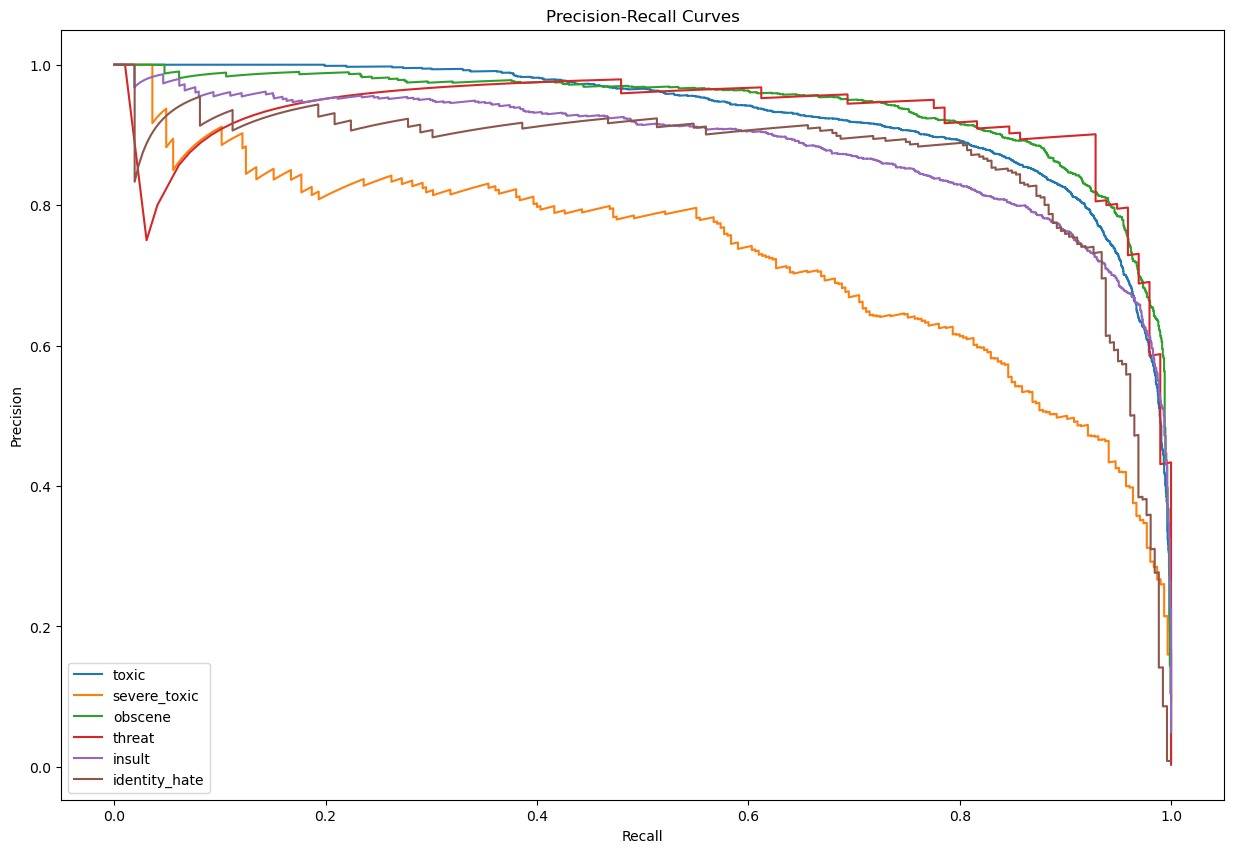

In [30]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plot_precision_recall_curves(model, val_loader, class_names, threshold=0.5)

## 2. ROC Curves:

ROC curves show the trade-offs between sensitivity (recall) and specificity for each class.

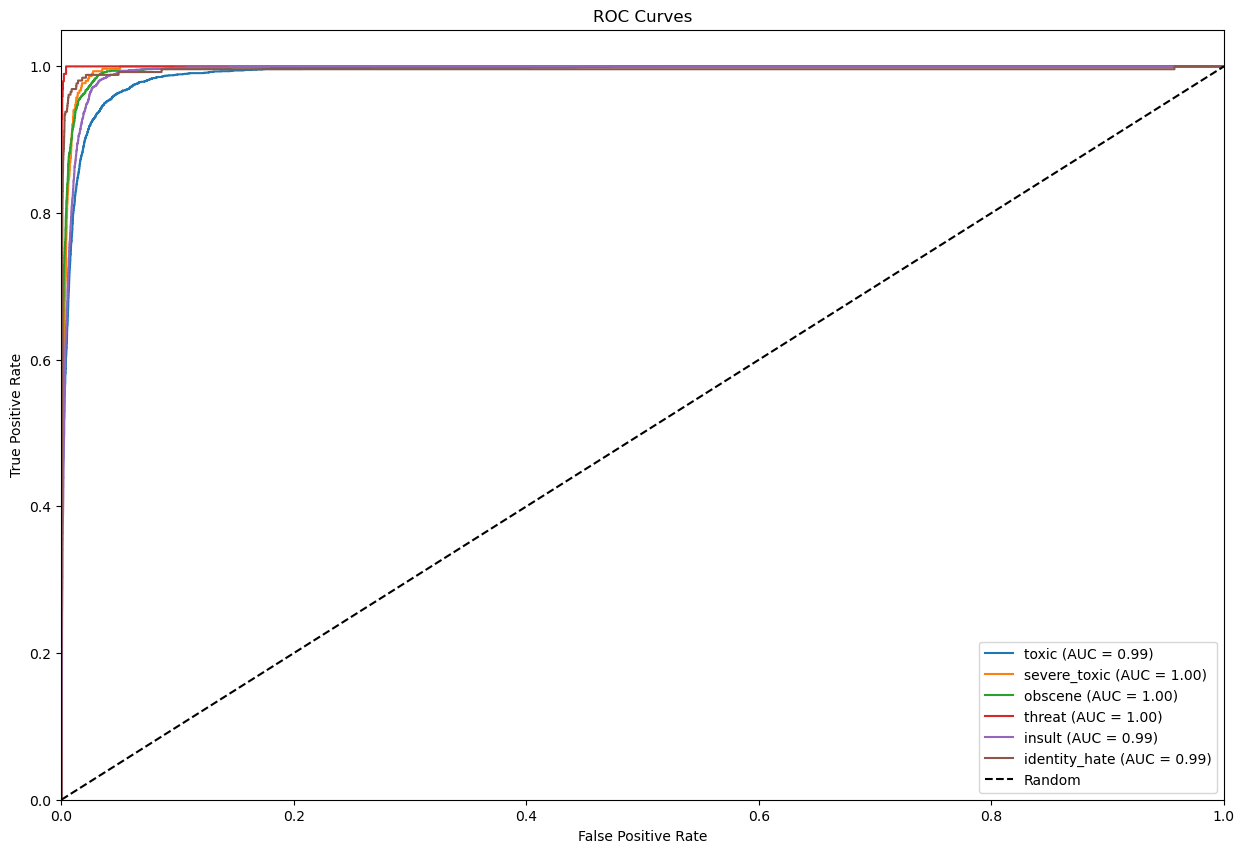

In [31]:
plot_roc_curves(model, val_loader, class_names, threshold=0.5)

# Model Three

## Model Architecture

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    problem_type="multi_label_classification", 
    num_labels=6)

class MultiLabelDistilBERT(nn.Module):
    def __init__(self, base_model):
        super(MultiLabelDistilBERT, self).__init__()
        self.base_model = base_model
        self.sigmoid = Sigmoid()

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = self.sigmoid(logits)
        return probs

model = MultiLabelDistilBERT(model)

print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiLabelDistilBERT(
  (base_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

MultiLabelDistilBERT(
  (base_model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

## Training Process

In [11]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['cleaned_comment_text']  
        self.labels = dataframe[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment = str(self.comment_text.iloc[index])  
        inputs = self.tokenizer(
            comment,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(self.labels[index], dtype=torch.float)
        }

In [12]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

In [40]:
criterion = FocalLoss()

optimizer = AdamW(model.parameters(), lr=5e-5)  

num_epochs = 5

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train() 
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training complete!")

Training Epoch 1/5: 100%|██████████| 9974/9974 [2:42:19<00:00,  1.02it/s]  


Epoch 1/5, Average Loss: 0.0128


Training Epoch 2/5: 100%|██████████| 9974/9974 [2:35:35<00:00,  1.07it/s]  


Epoch 2/5, Average Loss: 0.0099


Training Epoch 3/5: 100%|██████████| 9974/9974 [2:36:50<00:00,  1.06it/s]  


Epoch 3/5, Average Loss: 0.0084


Training Epoch 4/5: 100%|██████████| 9974/9974 [2:52:31<00:00,  1.04s/it]  


Epoch 4/5, Average Loss: 0.0072


Training Epoch 5/5:  36%|███▌      | 3570/9974 [57:55<1:48:27,  1.02s/it]

My computer decided to restart for a window's update on the 5th epoch, so I had to restart the training process. 

In [18]:
criterion = FocalLoss()

optimizer = AdamW(model.parameters(), lr=5e-5)  

num_epochs = 5

model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()  
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training complete!")

Training Epoch 1/5: 100%|██████████| 9974/9974 [2:25:17<00:00,  1.14it/s]  


Epoch 1/5, Average Loss: 0.0129


Training Epoch 2/5: 100%|██████████| 9974/9974 [2:25:53<00:00,  1.14it/s]  


Epoch 2/5, Average Loss: 0.0099


Training Epoch 3/5: 100%|██████████| 9974/9974 [2:29:17<00:00,  1.11it/s]  


Epoch 3/5, Average Loss: 0.0082


Training Epoch 4/5: 100%|██████████| 9974/9974 [2:34:41<00:00,  1.07it/s]  


Epoch 4/5, Average Loss: 0.0070


Training Epoch 5/5: 100%|██████████| 9974/9974 [2:29:19<00:00,  1.11it/s]  

Epoch 5/5, Average Loss: 0.0059
Training complete!


# Model Three Evaluation 

## Validation Results

In [19]:
val_df = X_val.join(y_val)

val_dataset = ToxicCommentsDataset(val_df, tokenizer, max_len=128)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

precision, recall, f1, roc_auc = evaluate_model(model, val_loader, threshold=0.5)

print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation ROC-AUC: {roc_auc:.4f}")

Validation Precision: 0.9165
Validation Recall: 0.9244
Validation F1-Score: 0.9169
Validation ROC-AUC: 0.9595


## Thresholding

In [20]:
for threshold in [0.3, 0.5, 0.7]:
    print(f"Evaluating with threshold = {threshold}")
    precision, recall, f1, roc_auc = evaluate_model(model, val_loader, threshold=threshold)
    
    print(f"Threshold: {threshold}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)

Evaluating with threshold = 0.3
Threshold: 0.3
Validation Precision: 0.7836
Validation Recall: 0.9883
Validation F1-Score: 0.8691
Validation ROC-AUC: 0.9861
--------------------------------------------------
Evaluating with threshold = 0.5
Threshold: 0.5
Validation Precision: 0.9165
Validation Recall: 0.9244
Validation F1-Score: 0.9169
Validation ROC-AUC: 0.9595
--------------------------------------------------
Evaluating with threshold = 0.7
Threshold: 0.7
Validation Precision: 0.9297
Validation Recall: 0.6317
Validation F1-Score: 0.7312
Validation ROC-AUC: 0.8155
--------------------------------------------------


## Test Set Performance

In [28]:
for threshold in [0.3, 0.5, 0.7]:
    print(f"Evaluating with threshold = {threshold}")
    precision, recall, f1, roc_auc = evaluate_model(model, test_loader, threshold=threshold)
    
    print(f"Threshold: {threshold}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print("-" * 50)

Evaluating with threshold = 0.3
Threshold: 0.3
Test Precision: 0.4650
Test Recall: 0.8816
Test F1-Score: 0.6031
Test ROC-AUC: 0.9011
--------------------------------------------------
Evaluating with threshold = 0.5
Threshold: 0.5
Test Precision: 0.5948
Test Recall: 0.7597
Test F1-Score: 0.6494
Test ROC-AUC: 0.8561
--------------------------------------------------
Evaluating with threshold = 0.7
Threshold: 0.7
Test Precision: 0.7399
Test Recall: 0.5012
Test F1-Score: 0.5510
Test ROC-AUC: 0.7411
--------------------------------------------------


In [30]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
generate_classification_report(model, val_loader, class_names, threshold=0.5)

               precision    recall  f1-score   support

        toxic       0.93      0.98      0.96      3046
 severe_toxic       0.72      0.65      0.69       305
      obscene       0.94      0.94      0.94      1662
       threat       0.79      0.95      0.86        98
       insult       0.91      0.92      0.91      1576
identity_hate       0.95      0.47      0.63       259

    micro avg       0.92      0.92      0.92      6946
    macro avg       0.87      0.82      0.83      6946
 weighted avg       0.92      0.92      0.92      6946
  samples avg       0.09      0.09      0.09      6946

Confusion Matrices:
[[[28648   221]
  [   54  2992]]

 [[31533    77]
  [  106   199]]

 [[30146   107]
  [   97  1565]]

 [[31792    25]
  [    5    93]]

 [[30191   148]
  [  125  1451]]

 [[31650     6]
  [  138   121]]]


In [31]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
generate_classification_report(model, test_loader, class_names, threshold=0.5)

               precision    recall  f1-score   support

        toxic       0.52      0.89      0.66      6090
 severe_toxic       0.33      0.47      0.39       367
      obscene       0.64      0.75      0.69      3691
       threat       0.48      0.59      0.53       211
       insult       0.67      0.68      0.68      3427
identity_hate       0.80      0.28      0.41       712

    micro avg       0.57      0.76      0.65     14498
    macro avg       0.57      0.61      0.56     14498
 weighted avg       0.59      0.76      0.65     14498
  samples avg       0.08      0.07      0.07     14498

Confusion Matrices:
[[[52887  5001]
  [  677  5413]]

 [[63251   360]
  [  193   174]]

 [[58746  1541]
  [  931  2760]]

 [[63635   132]
  [   87   124]]

 [[59403  1148]
  [ 1083  2344]]

 [[63215    51]
  [  513   199]]]


# Visualization of Model Three Performance

## 1. Precision-Recall Curves:
Precision-Recall curves give insights into the trade-offs between precision and recall for each class.

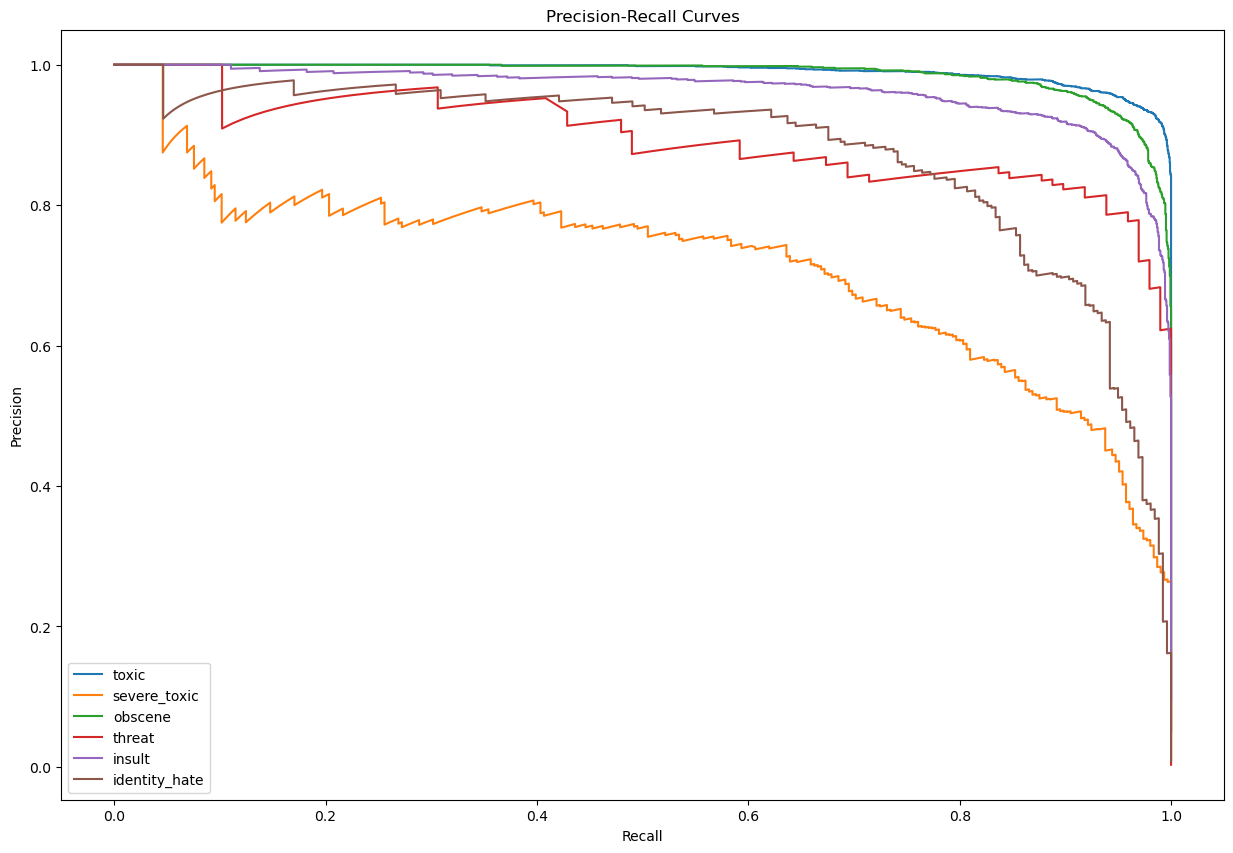

In [33]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plot_precision_recall_curves(model, val_loader, class_names, threshold=0.5)

## 2. ROC Curves:
ROC curves show the trade-offs between sensitivity (recall) and specificity for each class.

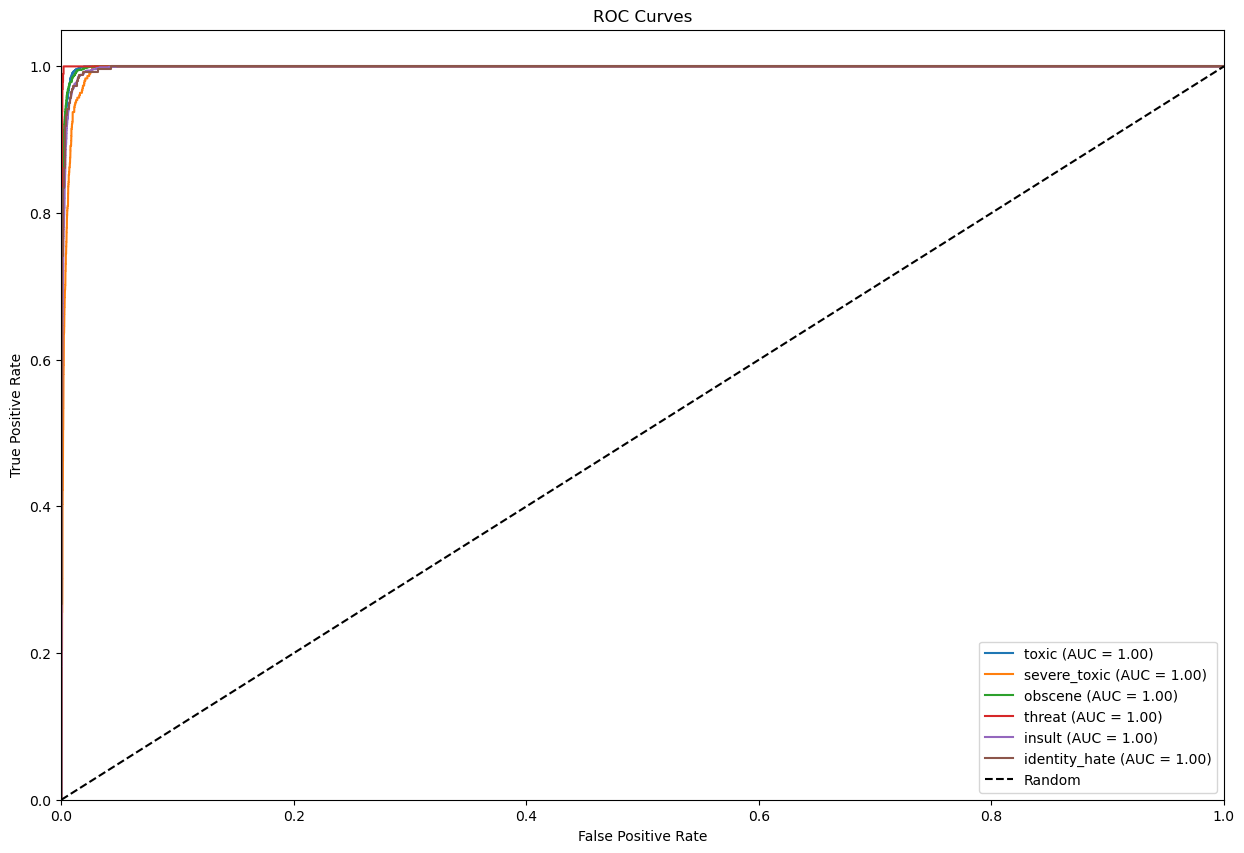

In [34]:
plot_roc_curves(model, val_loader, class_names, threshold=0.5)

# Results

#### **Validation Performance**:
| Metric                     | Model Two (Class Weights) | Model Three (Focal Loss) |
|----------------------------|---------------------------|--------------------------|
| **Precision (Threshold 0.5)**| 0.8561                    | 0.9165                   |
| **Recall (Threshold 0.5)**   | 0.8246                    | 0.9244                   |
| **F1-Score (Threshold 0.5)** | 0.8388                    | 0.9169                   |
| **ROC-AUC (Threshold 0.5)**  | 0.9078                    | 0.9595                   |

#### **Test Performance**:
| Metric                     | Model Two (Class Weights) | Model Three (Focal Loss) |
|----------------------------|---------------------------|--------------------------|
| **Precision (Threshold 0.5)**| 0.5788                    | 0.5948                   |
| **Recall (Threshold 0.5)**   | 0.7259                    | 0.7597                   |
| **F1-Score (Threshold 0.5)** | 0.6410                    | 0.6494                   |
| **ROC-AUC (Threshold 0.5)**  | 0.8425                    | 0.8561                   |

### Observations:

1. **Validation Results**:
   - **Focal Loss (Model Three)** outperforms **Class Weights (Model Two)** across all key metrics on the validation set. Focal loss achieves a **higher precision (0.9165 vs. 0.8561)**, **recall (0.9244 vs. 0.8246)**, and **F1-Score (0.9169 vs. 0.8388)**, indicating that it handles the validation data better, particularly in distinguishing minority classes.
   - The **ROC-AUC** score for focal loss (0.9595) is significantly higher than class weights (0.9078), showing better overall performance in distinguishing between classes.

2. **Test Results**:
   - On the test set, **Model Three (Focal Loss)** also marginally outperforms **Model Two (Class Weights)**. Focal loss achieves a **higher F1-Score (0.6494 vs. 0.6410)** and **higher ROC-AUC (0.8561 vs. 0.8425)**.
   - Focal loss demonstrates better performance in terms of **precision and recall** on the test set as well, with both scores slightly higher than those of the class-weighted model.

3. **Minority Class Performance**:
   - In the validation and test results, **Focal Loss (Model Three)** handles minority classes (like `severe_toxic` and `identity_hate`) better, as seen from higher recall and F1-scores in most cases, particularly in the validation set.
   - The confusion matrices also indicate better performance with focal loss in correctly classifying minority classes, especially on hard-to-classify examples like `threat` and `severe_toxic`.

### Conclusion:
- Model Three (Focal Loss) consistently outperforms **Model Two (Class Weights)** on both validation and test sets. The higher precision, recall, F1-scores, and ROC-AUC suggest that focal loss is better at handling the class imbalance problem, particularly with minority classes. Given this performance, I'll move forward with using focal loss for my final model as a focus on tuning the learning rate. 